# Import Module

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof
import random

# Plotting modules 
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from cartopy.util import add_cyclic_point

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist

# tqdm + Remove warnings
from tqdm import tqdm 
import warnings
warnings.filterwarnings('ignore')

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Settings

### Variables

In [2]:
variables = ['tas', 'pr', 'psl', 'SW', 'LW']
var_ceres = ['rsdt','rsut', 'rlut']
truncations = [18, 18, 8, 28, 22]
TITLE = 'Multi-variate'
ylabel = '$E_{tot}$'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/PPE/CNRM-CM6-1_PPE/'
path_files='/data/scratch/globc/peatier/HOME_files/PPE/CNRMppe_error_decomposition/files/'
path_file_npy = '/data/scratch/globc/peatier/HOME_files/PPE/ENSEMBLE2/files/npy/'

# Functions

In [4]:
def get_3D_tas_xarr(path, filename, variables):
#    “”"
#    This function read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    #
    return tas

In [5]:
def get_3D_pr_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    pr = df['pr']*86400 
    #
    return pr

In [6]:
def get_3D_psl_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    psl = df['psl']
    
    return psl

In [7]:
def get_3D_LW_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    LW = df['rlut']
    
    return LW

In [8]:
def get_3D_SW_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    SW = df['rsut']# - df['rsdt']
    
    return SW

In [9]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month
    
    #list_ind = []
    #cpt=0
    #for i in df1['year'] : 
    #    if i>1981 :
    #        list_ind.append(cpt)
    #        cpt+=1
    #    else : 
    #        cpt+=1
            
    #df2 = df1.drop(list_ind)
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

In [10]:
def MSE(mod, obs, W_rmse_2D) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = (diff_tmp.sum(['lat', 'lon']))
    return diff

In [11]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [12]:
def MSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_rmse_2D) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = MSE(mod, obs, W_rmse_2D)
    return diff

In [13]:
def MultiLinReg_pred(LHS, X ,y, param_names) :

    LHS_df = pd.DataFrame(LHS)

    lhs = LHS_df.values
    #LHS_df

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    N=len(LHS_df.values)
    tmp = [0]*N
    y_pred = [0]*N
    i=0
    Ycpt=0
    while i<N:
        
        tmp[i] = Coeffs.values*LHS_df.iloc[i]
        y_pred[i] = tmp[i].sum()+R
        i+=1

    #y_pred
    #members = arange(102,100102,1)
    #DFYpred = pd.DataFrame([y_pred, members], index=["y_pred", "members"]).transpose()
    return y_pred

# Get data 

In [14]:
path_file = path_files+'npy/'
Mean={}
for var in variables :
    filename = 'CNRMppe_decomposition_mean_'+str(var)+'.npy'
    Mean_tmp =  pd.read_pickle(path_file+filename).to_xarray().to_array()
    Mean[str(var)] = Mean_tmp[0,:,:].rename({'variable':'mode'})

In [15]:
variable = 'tas'
W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+str(variable)+'.npy')
W_eof_3D = np.load(path_files+'npy/W_eof_3D_'+str(variable)+'.npy')
W_rmse_2D = np.load(path_files+'npy/W_rmse_2D_'+str(variable)+'.npy')

### BEST observations - tas

In [16]:
path_observation = '/data/scratch/globc/peatier/obs/BEST/'
filename = 'Land_and_Ocean_LatLong1_regrid_1979-1981.nc'
var = 'tas'

In [17]:
# POUR LES OBSERVATIONS BEST ---- initial cells

path = path_observation

file =  xr.open_mfdataset(path+filename,combine='by_coords')
clim = file['climatology'].to_dataframe()#.drop(columns='month_number')
clim = pd.concat([clim, clim, clim]).reset_index('month_number')

df_obs=file['temperature'].to_dataframe().reset_index('time')
df_obs['clim'] = clim['climatology']
df_obs['tas'] = df_obs['temperature']+df_obs['clim']+273.15
variable_obs = 'ta'

In [18]:
obs = {}
obs[var] = df_obs[var].groupby(['lat','lon']).mean().to_xarray()

### GPCP observations - pr

In [19]:
path_observation = '/data/scratch/globc/peatier/obs/GPCP/regrid_CNRM/'
filename_obs = 'pr_mon_mean_197901-198112_regrid.nc'
var = 'pr'

In [20]:
## --- Initial method
path = path_observation
df_obs = load_monthly_clim(path, filename_obs, var)
obs[var] = df_obs[var].groupby(['lat','lon']).mean().to_xarray()

### CERES observations

In [21]:
path_observation = '/data/scratch/globc/peatier/obs/CERES/'
filename = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-201910_regrid.nc'

In [22]:
# Load data and compute Annual Cycle :
file = xr.open_mfdataset(path_observation+filename,combine='by_coords')
#file
variables = ['toa_sw_all_mon','toa_lw_all_mon', 'toa_net_all_mon']
df_obs = load_monthly_clim(path_observation, filename, variables)
df_obs

toa_sw_all_mon  toa_lw_all_mon  toa_net_all_mon
month lat        lon                                                       
1     -88.927735 0.00000        344.953522      189.246185       -38.599289
                 1.40625        344.953522      189.246185       -38.599289
                 2.81250        344.953522      189.246185       -38.599289
                 4.21875        344.992493      189.144440       -38.531315
                 5.62500        345.007721      189.104630       -38.504715
...                                    ...             ...              ...
12     88.927735 352.96875        0.000000      171.476639      -171.476639
                 354.37500        0.000000      171.476639      -171.476639
                 355.78125        0.000000      171.500351      -171.500351
                 357.18750        0.000000      171.560974      -171.560974
                 358.59375        0.000000      171.560974      -171.560974

[393216 rows x 3 columns]

In [23]:
df_obs['SW'] =   df_obs['toa_sw_all_mon']# + df_obs['toa_lw_all_mon']
obs['SW'] = df_obs.groupby(['lat','lon']).mean().to_xarray()

df_obs['LW'] =  df_obs['toa_lw_all_mon']
obs['LW'] = df_obs.groupby(['lat','lon']).mean().to_xarray()

In [24]:
df_obs['SW']

month  lat         lon      
1      -88.927735  0.00000      344.953522
                   1.40625      344.953522
                   2.81250      344.953522
                   4.21875      344.992493
                   5.62500      345.007721
                                   ...    
12      88.927735  352.96875      0.000000
                   354.37500      0.000000
                   355.78125      0.000000
                   357.18750      0.000000
                   358.59375      0.000000
Name: SW, Length: 393216, dtype: float32

### NCEP observations

In [25]:
path_observation =  '/data/scratch/globc/peatier/obs/NCEP/regrid_CNRM/'
filename_obs = 'psl_1m_1979-1981_NCEP_regrid.nc'

In [26]:
# Load data and compute Annual Cycle :
file = xr.open_mfdataset(path_observation+filename_obs,combine='by_coords')
#file
variables = ['psl']
df_obs = load_monthly_clim(path_observation, filename_obs, variables)
df_obs

psl
month lat        lon                     
1     -88.927735 0.00000     99413.804688
                 1.40625     99413.843750
                 2.81250     99413.851562
                 4.21875     99413.757812
                 5.62500     99413.578125
...                                   ...
12     88.927735 352.96875  101209.882812
                 354.37500  101209.617188
                 355.78125  101209.382812
                 357.18750  101209.171875
                 358.59375  101208.929688

[393216 rows x 1 columns]

In [27]:
obs['psl'] = df_obs.groupby(['lat','lon']).mean().to_xarray()

### Weighted anomaly

In [28]:
variables = ['tas', 'pr', 'psl', 'SW', 'LW']

In [29]:
X_obs = dict()
X_obs_w = dict()
for var in variables :
    W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+str(var)+'.npy')
    W_eof_3D = np.load(path_files+'npy/W_eof_3D_'+str(var)+'.npy')
    W_rmse_2D = np.load(path_files+'npy/W_rmse_2D_'+str(var)+'.npy')

    ## --Observations
    X_obs[var] = obs[var] - Mean[var]
    X_obs_w[var] = X_obs[var]*W_eof_2D

### Download PCs

In [30]:
#path_files = '/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/files/'
pc_PPE = {}
pc_p1 = {}
pc_pred = {}
pc_cand_emul = {}
pc_obs = {}

for var in tqdm(variables) :
    ## PPE
    path = path_files+'nc/'
    filename = 'pc_PPE_'+var+'.nc'
    pc_PPE[var] = xr.open_mfdataset(path+filename,combine='by_coords')
    dims_dict = {'time' : 'members', 'mode' : 'modes'}
    pc_PPE[var] = pc_PPE[var].rename_dims(dims_dict)
    
    ## observations
    path = path_files+'nc/'
    filename = 'pc_obs_'+var+'.nc'
    pc_obs[var] = xr.open_mfdataset(path+filename,combine='by_coords')
    
    ## p1 - the first line of pc_PPE
    pc_p1[var] = pc_PPE[var]['pcs'][0,:]
    
    ## predictions
    path = path_files+'nc/'
    filename = 'pc_pred_'+var+'.nc'
    pc_pred[var] = xr.open_mfdataset(path+filename,combine='by_coords')
    pc_pred[var] = pc_pred[var].rename({'__xarray_dataarray_variable__' : 'pcs'})

    ## emulated candidates 
    path = path_files+'nc/'
    filename = 'PC_candidates_multi_kmedian.nc'
    pc_cand_emul_tmp = xr.open_mfdataset(path+filename,combine='by_coords')
    pc_cand_emul_tmp = pc_cand_emul_tmp.rename({'__xarray_dataarray_variable__' : 'pcs'}) 

100%|██████████| 5/5 [00:00<00:00, 12.25it/s]


In [31]:
pc_cand_emul = {}
cpt = 0
cpt1 = 0
for var in tqdm(variables) :
    trunc = truncations[cpt]
    cpt2 = cpt1+trunc
    pc_cand_emul[var] = pc_cand_emul_tmp['pcs'][:,cpt1:cpt2]
    cpt1 = cpt2
    cpt += 1

100%|██████████| 5/5 [00:00<00:00, 3518.71it/s]


In [32]:
#path_files = '/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/files/'
path = path_files+'nc/'
pc_optim = {}
for var in variables :
    filename = 'optim_pc_PPE_'+var+'_multi.nc'
    pc_optim[var] = xr.open_mfdataset(path+filename,combine='by_coords')

In [33]:
df_optim = {}
cpt=0
for var in variables :
    df_optim[var] = pd.DataFrame()
    trunc = truncations[cpt]
    for i in range(1,trunc+1,1) :
        df_optim[var]['EOF '+str(i)] = pc_optim[var]['EOF '+str(i)].values
    df_optim[var]['LHS index'] = pc_optim[var]['LHS index'].values
    cpt+=1

### EOF solver can be loaded from here 

In [34]:
import pickle
path = path_files+'pkl/'
solver = {}
for var in variables :
    print(var)

    # open a file, where you stored the pickled data
    file = open(path+'solver_'+var+'.pkl', 'rb')

    # dump information to that file
    solver[var] = pickle.load(file)

    # close the file
    file.close()

tas
pr
psl
SW
LW


In [35]:
eofs = {}
variances = {}
for var in variables :
    eofs[var] = solver[var].eofsAsCovariance(pcscaling=1)
    variances[var] = solver[var].varianceFraction() 

In [36]:
cpt = 0
for var in variables :
    print(var)
    trunc = truncations[cpt]
    print(trunc)
    v = variances[var][0:trunc].sum()
    print(float(v))
    cpt+=1

tas
18
0.9453142157053153
pr
18
0.8541554866051219
psl
8
0.9206052424899763
SW
28
0.9734259676271958
LW
22
0.9628472925788145


In [37]:
# Reference simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'

p1_amip = dict()
diff_p1 = dict()
X_p1_w = dict()

for var in ['tas', 'psl'] :
    print(var)
    p1_amip[var] = load_monthly_clim(path, filename, var).groupby(['lat','lon']).mean().to_xarray()
    
    ## --Full error e(\theta_0)
    mod = p1_amip[var]
    observation = obs[var]
    diff_p1[var] = MSE(mod, observation, W_rmse_2D)
    
    ## --Anom and weight
    W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+str(var)+'.npy')
    X_p1 = p1_amip[var] - Mean[var]
    X_p1_w[var] = X_p1*W_eof_2D
    
### --- CERES data

df_ceres = load_monthly_clim(path, filename, var_ceres)

df_ceres['SW'] = df_ceres['rsut']# - df_ceres['rsdt']
p1_amip['SW'] = df_ceres.groupby(['lat','lon']).mean().to_xarray()

df_ceres['LW'] =  df_ceres['rlut']
p1_amip['LW'] = df_ceres.groupby(['lat','lon']).mean().to_xarray()

for var in ['SW', 'LW'] :
    print(var)
    
    ## --Full error e(\theta_0)
    mod = p1_amip[var]
    observation = obs[var]
    diff_p1[var] = MSE(mod, observation, W_rmse_2D)
    
    ## --Anom and weight
    W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+str(var)+'.npy')
    X_p1 = p1_amip[var] - Mean[var]
    X_p1_w[var] = X_p1*W_eof_2D
 
### --- Precipitation pr 

var = 'pr'
print(var)
p1_amip[var] = load_monthly_clim(path, filename, var).groupby(['lat','lon']).mean().to_xarray()
    
## --Full error e(\theta_0)
mod = p1_amip[var]*86400
observation = obs[var]
diff_p1[var] = MSE(mod, observation, W_rmse_2D)
    
## --Anom and weight
W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+str(var)+'.npy')
X_p1 = p1_amip[var]*86400 - Mean[var]
X_p1_w[var] = X_p1*W_eof_2D
 

tas
psl
SW
LW
pr


In [38]:
lat = X_p1_w['tas']['lat']
lon = X_p1_w['tas']['lon']
eofs_nb = arange(1,104,1)
eofs_xr = {}
eofs_combined = {}

for var in tqdm(variables) :
    eofs_xr[var] = xr.DataArray(eofs[var], 
                   coords={'eofs': eofs_nb,'lat': lat,'lon': lon}, 
                   dims=["eofs", "lat", "lon"])#.to_dataset(name=var)
    ## --Combine the modes for reconstruction
    eofs_combined[var] = eofs_xr[var]

100%|██████████| 5/5 [00:00<00:00, 1970.45it/s]


## Analysis of CNRM-CM candidates runs

In [39]:
def get_3D_tas_xarr(path, filename, variables):
#    “”"
#    This function read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    #
    return tas

In [40]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix 
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [41]:
nb_p_select = ['p985', 'p986', 'p987', 'p988',
              'p989', 'p990', 'p991', 'p992',
               'p995', 'p996']

In [42]:
# Change Dataset into DataArray

obs['psl']= obs['psl']['psl'] 
obs['SW']= obs['SW']['SW'] 
obs['LW']= obs['LW']['LW'] 

In [43]:
## -- CNRM-CM candidates simulations :
filename='*_amip_*.nc'
amip_select={}
path_sel = path_PPE+'ENSEMBLE5/CNRM-CM6-1_amip_PPE_ENSEMBLE5/ESD_2024_select_k_median/select_multi/'

for var in variables : 
    amip_select[var] = {}

for p in tqdm(nb_p_select) :
    #print(p)
    
    path=path_sel+'CNRM-CM6-1_amip_r1i1'+p+'f2/'
    
    ## -- tas 
    var=['tas']
    amip_tmp = get_3D_tas_xarr(path, filename, var)
    amip_select[var[0]][p] = amip_tmp
    
    ## -- pr 
    var=['pr']
    amip_tmp = get_3D_pr_xarr(path, filename, var)
    amip_select[var[0]][p] = amip_tmp
    
    ## -- psl
    var=['psl']
    amip_tmp = get_3D_psl_xarr(path, filename, var)
    amip_select[var[0]][p] = amip_tmp
    
    ## -- SW 
    var=['rsdt', 'rsut']
    amip_tmp = get_3D_SW_xarr(path, filename, var)
    amip_select['SW'][p] = amip_tmp
    
    ## -- LW 
    var=['rlut']
    amip_tmp = get_3D_LW_xarr(path, filename, var)
    amip_select['LW'][p] = amip_tmp

100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


In [44]:
## --Reconstruct observations 
X_obs_rec = {}
U_obs = {}
cpt=0
for var in tqdm(variables) :
    trunc = truncations[cpt]
    
    ## -- Project :
    X_obs_w = (obs[var] - Mean[var])*W_eof_2D
    U_obs[var] = solver[var].projectField(X_obs_w, weighted=False, 
                                             eofscaling=1)
    
    ## --Reconstruct :
    X_obs_rec[var] = reconstruct_X(eofs_combined[var][0:trunc,:,:], pc=U_obs[var][0:trunc], 
                                      nb_dims=2)
    cpt+=1

100%|██████████| 5/5 [00:00<00:00, 20.12it/s]


In [45]:
## --Analysis of the candidates  :
e_sel = {}
U_sel = {}
X_sel_rec = {}
p_sel = {}
cpt=0

for var in tqdm(variables) :
    #print(var)

    e_sel_list = []
    U_sel_list = []
    X_sel_rec_list = []
    p_sel_list = []
    
    trunc = truncations[cpt]
    
    for p in nb_p_select :
        
        X_sel = amip_select[var][p]
        #print(X_sel)
        
        ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix :
        X_sel['lat'] = eofs_combined[var]['lat']
        X_sel['lon'] = eofs_combined[var]['lon']
          
        ## -- Full error MSE : 
        e_sel_tmp = MSE(X_sel, obs[var], W_rmse_2D)
        e_sel_list.append(e_sel_tmp)
    
        ## -- Project the candidates :
        X_sel_w = (X_sel - Mean[var])*W_eof_2D
        U_sel_tmp = solver[var].projectField(X_sel_w, weighted=False, 
                                             eofscaling=1)
        U_sel_list.append(U_sel_tmp)
    
        ## --Reconstruct the candidates :
        X_sel_rec_tmp = reconstruct_X(eofs_combined[var][0:trunc,:,:], pc=U_sel_tmp[0:trunc], 
                                      nb_dims=2)
        X_sel_rec_list.append(X_sel_rec_tmp)
    
        ## -- Parametric errors RMSE_rec : 
        p_sel_tmp = MSE_rec(X_sel_rec_tmp, X_obs_rec[var], Mean[var], W_rmse_2D)
        p_sel_list.append(float(p_sel_tmp))
        
        ## -- Non-parametric error :
    
    e_sel[var] = e_sel_list
    U_sel[var] = U_sel_list
    X_sel_rec[var] = X_sel_rec_list
    p_sel[var] = p_sel_list
    cpt+=1

100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


In [46]:
## -- Faire DataFrame :
df_sel = {}
cpt=0
for var in tqdm(variables) :
    df_sel[var] = pd.DataFrame([None]*len(p_sel[var]), columns= ['index'])
    U_sel_list = {}
    trunc = truncations[cpt]
    for mode_nb in range(0,trunc,1) :
        U_sel_list = []
        for cand_nb in range(0,len(p_sel[var]),1) :
            tmp = float(U_sel[var][cand_nb][mode_nb])
            U_sel_list.append(tmp)
        
        df_sel[var]['EOF '+str(mode_nb+1)] = U_sel_list
    
    df_sel[var]['p'] = p_sel[var]
    cpt+=1

100%|██████████| 5/5 [00:00<00:00, 49.03it/s]


# Analysis CNRM-CM candidates

In [47]:
def diff_3D_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_rmse_2D) :
    
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = mod - obs
    
    return diff
    

In [48]:
## --Analysis of the candidates  :
e_diff = {}
u_diff = {}
p_diff = {}
e_sel = {}
u_sel = {}
cpt=0

for var in tqdm(variables) :
    #print(var)

    e_diff_list = []
    u_diff_list = []
    p_diff_list = []
    e_sel_list = []
    u_sel_list = []
    
    trunc = truncations[cpt]
    
    for p in nb_p_select :
        
        X_sel = amip_select[var][p]
        #print(X_sel)
        
        ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix :
        X_sel['lat'] = eofs_combined[var]['lat']
        X_sel['lon'] = eofs_combined[var]['lon']
          
        ## -- 3D full error [obs - mod]
        e_diff_tmp = (X_sel - obs[var])
        e_diff_list.append(e_diff_tmp)
    
         ## -- Project the candidates :
        X_sel_w = (X_sel - Mean[var])*W_eof_2D
            
        U_sel = solver[var].projectField(X_sel_w, weighted=False, eofscaling=1)
    
        ## --Reconstruct the candidates :
        X_sel_rec = reconstruct_X(eofs_combined[var][0:trunc,:,:], pc=U_sel[0:trunc], nb_dims=2)
    
        ## -- 3D p error [X_obs_rec - X_mod_rec]
        p_diff_tmp = diff_3D_rec(X_sel_rec, X_obs_rec[var], Mean[var], W_rmse_2D)
        p_diff_list.append(p_diff_tmp)
    
        ## -- 3D u error [e - p]
        u_diff_tmp = (e_diff_tmp - p_diff_tmp)
        u_diff_list.append(u_diff_tmp)
        
        ## -- Compute integrated metrics 
    
        ## -- Compute RMSE 
        e = MSE(X_sel, obs[var], W_rmse_2D)
        #print(float(e))
        e_sel_list.append(float(e))
        
        ## - non-param. error u(\theta_0)
        diff = u_diff_tmp**2 * W_rmse_2D
        u = (diff.sum(['lat', 'lon']))
        u_sel_list.append(float(u))
    
    e_diff[var] = e_diff_list
    #print(e_diff[var])
    u_diff[var] = u_diff_list
    p_diff[var] = p_diff_list
    e_sel[var] = e_sel_list
    u_sel[var] = u_sel_list
    df_sel[var]['e'] = e_sel_list
    df_sel[var]['u'] = u_sel_list
    cpt+=1

100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


In [49]:
## -- p1 reference CNRM-CM6-1

## -- convert p1_amip['pr'] en mm/day
p1_amip['pr'] = p1_amip['pr']*86400

In [50]:
## -- p1 reference CNRM-CM6-1

X_p1_rec = {}
e_diff_p1 = {}
e_p1 = {}
p_p1 = {}
u_p1 = {}
U_p1 = {}
p_diff_p1 = {}
u_diff_p1 = {}
cpt = 0

for var in tqdm(variables) :
    #print(var)
    trunc = truncations[cpt]

    ## -- 3D full error [obs - mod]
    e_diff_p1[var] = (p1_amip[var] - obs[var])

    ## -- Project 
    X_sel = p1_amip[var]
    X_p1 = X_sel - Mean[var]
    X_p1_w = X_p1*W_eof_2D
    U_p1[var] = solver[var].projectField(X_p1_w[var], weighted=False, eofscaling=1)

    ## --Reconstruct 
    X_p1_rec[var] = reconstruct_X(eofs_combined[var][0:trunc,:,:], pc=U_p1[var][0:trunc], 
                                  nb_dims=2)

    ## -- 3D p error [X_obs_rec - X_mod_rec]
    p_diff_p1[var] = diff_3D_rec(X_p1_rec[var], X_obs_rec[var], Mean[var], W_rmse_2D)

    ## -- 3D u error [e - p]
    u_diff_p1[var] = (e_diff_p1[var] - p_diff_p1[var])
    
    ## - integrated metric 
    e = MSE(X_sel, obs[var], W_rmse_2D)
    e_p1[var] = float(e[var])

    ## --Param. error p(\theta_0)
    p = MSE_rec(X_p1_rec[var], X_obs_rec[var], Mean[var], W_rmse_2D)
    p_p1[var] = float(p)
    #print(e_p1[var])
    
    ## - non-param. error u(\theta_0)
    diff = u_diff_p1[var]**2 * W_rmse_2D
    u = (diff.sum(['lat', 'lon']))
    u_p1[var] = float(u[var])
    
    cpt+=1

100%|██████████| 5/5 [00:00<00:00, 18.96it/s]


In [51]:
## -- e_tot
e_tot = []
for i in range(0,len(p_sel[var]), 1) :
    s = 0
    for var in variables :
        s = s + e_sel[var][i]/e_p1[var] 
    e = s/len(variables)
    e_tot.append(float(e))
e_tot

[1.5606254946422948,
 1.0925449368280662,
 1.3250530611876994,
 1.4449206449947396,
 1.0093784926894531,
 1.100022182696187,
 1.254197674881972,
 1.395038343531611,
 1.2910080511008961,
 1.0554792716048138]

## GMMIP

In [52]:
def get_3D_tas_xarr_gmmip(path, filename, variables):
#    “”"
#    This function read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename, combine='nested', concat_dim='member')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)#.rename({'member' : 'time'})
    tas = df['tas']
    #
    return tas

def get_3D_pr_xarr_gmmip(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename, combine='nested', concat_dim='member')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)#.rename({'member' : 'time'})
    pr = df['pr']*86400 
    #
    return pr

def get_3D_psl_xarr_gmmip(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename, combine='nested', concat_dim='member')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)#.rename({'member' : 'time'})
    psl = df['psl']
    
    return psl

def get_3D_LW_xarr_gmmip(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename, combine='nested', concat_dim='member')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)#.rename({'member' : 'time'})
    LW = df['rlut']
    
    return LW

def get_3D_SW_xarr_gmmip(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename, combine='nested', concat_dim='member')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)#.rename({'member' : 'time'})
    SW = df[variables]
    
    return SW

In [53]:
## -- pour GMMIP
path_CMIP6 = '/data/scratch/globc/peatier/CMIP/ESGF_download_wget/model_outputs/CMIP6/'
path_GMMIP = path_CMIP6+'CNRM-CM6-1/GMMIP/CNRM/'
filename = '*_Amon*.nc'
gmmip = {}

## -- tas 
variables=['tas']
var ='tas'
filename = var+'*_Amon*.nc'
path = path_GMMIP+var+'/'
gmmip[var] = get_3D_tas_xarr_gmmip(path, filename, variables)
#print(gmmip[var])
    
## -- pr 
variables = ['pr']
var = 'pr'
filename = var+'*_Amon*.nc'
path = path_GMMIP+var+'/'
gmmip[var] = get_3D_pr_xarr_gmmip(path, filename, variables)
#print(gmmip[var])
    
## -- psl
variables = ['psl']
var = 'psl'
filename = var+'*_Amon*.nc'
path = path_GMMIP+var+'/'
gmmip[var] = get_3D_psl_xarr_gmmip(path, filename, variables)
#print(gmmip[var])
    
## -- SW 
variables = ['rsdt', 'rsut']
var = 'SW'
path = path_GMMIP+var+'/'

filename = variables[0]+'*_Amon*.nc'
amip_tmp1 = get_3D_SW_xarr_gmmip(path, filename, [variables[0]])

filename = variables[1]+'*_Amon*.nc'
amip_tmp2 = get_3D_SW_xarr_gmmip(path, filename, [variables[1]])

SW = amip_tmp2['rsut']# - amip_tmp1['rsdt']

gmmip[var] = SW
#print(gmmip[var])
    
## -- LW 
variables = ['rlut']
var = 'LW'
path = path_GMMIP+var+'/'
filename = variables[0]+'*_Amon*.nc'
gmmip[var] = get_3D_LW_xarr_gmmip(path, filename, variables)
#print(gmmip[var])

In [54]:
## --Analysis of the candidates  :
e_diff_gmmip = {}
u_diff_gmmip = {}
p_diff_gmmip = {}
e_gmmip = {}
u_gmmip = {}
cpt=0

variables = ['tas', 'pr', 'psl', 'SW', 'LW']

for var in tqdm(variables) :
    
    #print(var)

    e_diff_list = []
    u_diff_list = []
    p_diff_list = []
    e_sel_list = []
    u_sel_list = []
    
    trunc = truncations[cpt]
    if var=='psl':
        list_mb = [0,1,2,3,4,5,6,7]
    else : 
        list_mb = [0,1,3,4,5,6,7,8]
    
    for i in list_mb :
        
        X_sel = gmmip[var][i,:,:]
        #print(X_sel)
        
        ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix :
        X_sel['lat'] = eofs_combined[var]['lat']
        X_sel['lon'] = eofs_combined[var]['lon']
          
        ## -- 3D full error [obs - mod]
        e_diff_tmp = (X_sel - obs[var])
        e_diff_list.append(e_diff_tmp)
    
         ## -- Project the candidates :
        X_sel_w = (X_sel - Mean[var])*W_eof_2D
        U_sel = solver[var].projectField(X_sel_w, weighted=False, eofscaling=1)
    
        ## --Reconstruct the candidates :
        X_sel_rec = reconstruct_X(eofs_combined[var][0:trunc,:,:], pc=U_sel[0:trunc], nb_dims=2)
    
        ## -- 3D p error [X_obs_rec - X_mod_rec]
        p_diff_tmp = diff_3D_rec(X_sel_rec, X_obs_rec[var], Mean[var], W_rmse_2D)
        p_diff_list.append(p_diff_tmp)
    
        ## -- 3D u error [e - p]
        u_diff_tmp = (e_diff_tmp - p_diff_tmp)
        u_diff_list.append(u_diff_tmp)
        
        ## -- Compute integrated metrics 
    
        ## -- Compute RMSE 
        e = MSE(X_sel, obs[var], W_rmse_2D)
        #print(float(e))
        e_sel_list.append(float(e))
        
        ## - non-param. error u(\theta_0)
        diff = u_diff_tmp**2 * W_rmse_2D
        u = (diff.sum(['lat', 'lon']))
        u_sel_list.append(float(u))
    
    e_diff_gmmip[var] = e_diff_list
    #print(e_diff[var])
    u_diff_gmmip[var] = u_diff_list
    p_diff_gmmip[var] = p_diff_list
    e_gmmip[var] = e_sel_list
    u_gmmip[var] = u_sel_list
    #df_gmmip[var]['e'] = e_sel_list
    #df_gmmip[var]['u'] = u_sel_list
    cpt+=1

100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


In [55]:
## --- etot GMMIP 

e_tot_gmmip = []
for i in [0,1,2,3,4,5,6,7] :
    s = 0
    for var in variables :
        s = s + e_gmmip[var][i]/e_p1[var] 
    e = s/len(variables)
    e_tot_gmmip.append(e)
e_tot_gmmip

[1.0770537818633361,
 1.012959405692912,
 1.0922857438637594,
 1.0395857824558874,
 1.03073560027723,
 1.047179363858387,
 1.0171217014676521,
 1.0467938290808887]

## Full PPE

In [56]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

In [57]:
# PPE amip simulations 
filename='*_amip_*.nc'
N=len(nb_p_list)
amip_PPE = {}
amip_tas = []
amip_pr = []
amip_psl = []
amip_SW = []
amip_LW = []

for nb_p in tqdm(nb_p_list) :
    #print(nb_p)
    path = path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip_tas.append(get_3D_tas_xarr(path, filename, ['tas']))
    amip_pr.append(get_3D_pr_xarr(path, filename, ['pr']))
    amip_psl.append(get_3D_psl_xarr(path, filename, ['psl']))
    amip_SW.append(get_3D_SW_xarr(path, filename, var_ceres))
    amip_LW.append(get_3D_LW_xarr(path, filename, var_ceres))

amip_PPE[variables[0]] = amip_tas
amip_PPE[variables[1]] = amip_pr
amip_PPE[variables[2]] = amip_psl
amip_PPE[variables[3]] = amip_SW
amip_PPE[variables[4]] = amip_LW

100%|██████████| 102/102 [07:19<00:00,  4.31s/it]


In [58]:
matrix = {}

for var in tqdm(variables) :
    matrix[var] = xr.combine_nested(amip_PPE[var], concat_dim=['time'])

100%|██████████| 5/5 [00:01<00:00,  4.82it/s]


In [59]:
## --Analysis of the candidates  :
e_diff_ppe = {}
u_diff_ppe = {}
p_diff_ppe = {}
e_ppe = {}
u_ppe = {}
cpt=0

variables = ['tas', 'pr', 'psl', 'SW', 'LW']

for var in tqdm(variables) :
    
    #print(var)

    e_diff_list = []
    u_diff_list = []
    p_diff_list = []
    e_sel_list = []
    u_sel_list = []
    
    trunc = truncations[cpt]

    list_mb = range(0,102,1)
    
    for i in list_mb :
        #print(i)
        
        X_sel = matrix[var][i,:,:]
        #print(X_sel)
        
        ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix :
        X_sel['lat'] = eofs_combined[var]['lat']
        X_sel['lon'] = eofs_combined[var]['lon']
          
        ## -- 3D full error [obs - mod]
        e_diff_tmp = (X_sel - obs[var])
        e_diff_list.append(e_diff_tmp)
    
         ## -- Project the candidates :
        X_sel_w = (X_sel - Mean[var])*W_eof_2D
        U_sel = solver[var].projectField(X_sel_w, weighted=False, eofscaling=1)
    
        ## --Reconstruct the candidates :
        X_sel_rec = reconstruct_X(eofs_combined[var][0:trunc,:,:], pc=U_sel[0:trunc], nb_dims=2)
    
        ## -- 3D p error [X_obs_rec - X_mod_rec]
        p_diff_tmp = diff_3D_rec(X_sel_rec, X_obs_rec[var], Mean[var], W_rmse_2D)
        p_diff_list.append(p_diff_tmp)
    
        ## -- 3D u error [e - p]
        u_diff_tmp = (e_diff_tmp - p_diff_tmp)
        u_diff_list.append(u_diff_tmp)
        
        ## -- Compute integrated metrics 
    
        ## -- Compute RMSE 
        e = MSE(X_sel, obs[var], W_rmse_2D)
        #print(float(e))
        e_sel_list.append(float(e))
        
        ## - non-param. error u(\theta_0)
        diff = u_diff_tmp**2 * W_rmse_2D
        u = (diff.sum(['lat', 'lon']))
        u_sel_list.append(float(u))
    
    e_diff_ppe[var] = e_diff_list
    #print(e_diff[var])
    u_diff_ppe[var] = u_diff_list
    p_diff_ppe[var] = p_diff_list
    e_ppe[var] = e_sel_list
    u_ppe[var] = u_sel_list
    #df_gmmip[var]['e'] = e_sel_list
    #df_gmmip[var]['u'] = u_sel_list
    cpt+=1

100%|██████████| 5/5 [01:51<00:00, 22.24s/it]


In [60]:
## --- etot PPE
list_mb = range(0,102,1)
e_tot_ppe = []
for i in list_mb :
    s = 0
    for var in variables :
        s = s + e_ppe[var][i]/e_p1[var] 
    e = s/len(variables)
    e_tot_ppe.append(e)
#e_tot_ppe

## Multi-model CMIP6

In [61]:
mod_list=['GFDL-CM4', 
'GFDL-AM4', 
'GISS-E2-1-G', 
'IPSL-CM6A-LR', 
'MIROC6', 
'BCC-CSM2-MR', 
'BCC-ESM1', 
'CESM2', 
'CESM2-WACCM', 
'MRI-ESM2-0', 
'SAM0-UNICON', 
'FGOALS-f3-L', 
'CanESM5', 
'INM-CM4-8', 
'INM-CM5-0', 
'MPI-ESM-1-2-HAM', 
'CAMS-CSM1-0', 
'MPI-ESM1-2-HR', 
'NESM3', 
'KACE-1-0-G', 
'MPI-ESM1-2-LR', 
'NorESM2-LM', 
'E3SM-1-0', 
'NorCPM1',  
'FGOALS-g3', 
'ACCESS-ESM1-5', 
'TaiESM1', 
'EC-Earth3',  
'EC-Earth3-Veg', 
'CAS-ESM2-0',  
'CIESM', 
'CMCC-CM2-SR5', 
'EC-Earth3-AerChem', 
'IITM-ESM',
'CNRM-CM6-1',
'CNRM-ESM2-1',
'UKESM1-0-LL',
'HadGEM3-GC31-MM', 
'GISS-E2-2-G', 
'HadGEM3-GC31-LL', 
'MIROC-ES2L']

In [62]:
## -- pour CMIP6
path_CMIP = '/data/scratch/globc/peatier/CMIP/ESGF_download_wget/model_outputs/CMIP6/'
filename = 'standard_*_regrid.nc'
cmip = {}
cmip_tas = []
cmip_pr = []
cmip_psl = []
cmip_SW = []
cmip_LW = []

for mod in tqdm(mod_list) :
    #print(mod)

    ## -- tas 
    variables=['tas']
    var ='tas'
    path = path_CMIP+mod+'/'+var+'/'
    x = get_3D_tas_xarr_gmmip(path, filename, variables)
    cmip_tas.append(x)
    
    ## -- pr 
    variables = ['pr']
    var = 'pr'
    path = path_CMIP+mod+'/'+var+'/'
    x = get_3D_pr_xarr_gmmip(path, filename, variables)
    cmip_pr.append(x)
    
    ## -- psl
    variables = ['psl']
    var = 'psl'
    path = path_CMIP+mod+'/'+var+'/'
    x = get_3D_psl_xarr_gmmip(path, filename, variables)
    cmip_psl.append(x)
    
    ## -- SW 
    variables = ['rsdt', 'rsut']
    var = 'SW'

    path = path_CMIP+mod+'/'+variables[0]+'/'
    amip_tmp1 = get_3D_SW_xarr_gmmip(path, filename, [variables[0]])

    path = path_CMIP+mod+'/'+variables[1]+'/'
    amip_tmp2 = get_3D_SW_xarr_gmmip(path, filename, [variables[1]])

    SW = amip_tmp2['rsut']# - amip_tmp1['rsdt']

    cmip_SW.append(SW)
    
    ## -- LW 
    variables = ['rlut']
    var = 'LW'
    path = path_CMIP+mod+'/'+variables[0]+'/'
    x = get_3D_LW_xarr_gmmip(path, filename, variables)
    cmip_LW.append(x)

cmip['tas'] = cmip_tas
cmip['pr'] = cmip_pr
cmip['psl'] = cmip_psl
cmip['SW'] = cmip_SW
cmip['LW'] = cmip_LW

100%|██████████| 41/41 [00:11<00:00,  3.70it/s]


In [63]:
## --Analysis of the CMIP6 models  :
e_diff_cmip = {}
u_diff_cmip = {}
p_diff_cmip = {}
e_cmip = {}
u_cmip = {}
cpt=0

variables = ['tas', 'pr', 'psl', 'SW', 'LW']

for var in tqdm(variables):
    
    #print(var)

    e_diff_list = []
    u_diff_list = []
    p_diff_list = []
    e_sel_list = []
    u_sel_list = []
    
    trunc = truncations[cpt]
    list_mb = range(0,len(mod_list),1)
    
    for i in list_mb :
        
        X_sel = cmip[var][i][0,:,:]
        #print(X_sel)
        
        ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix :
        X_sel['lat'] = eofs_combined[var]['lat']
        X_sel['lon'] = eofs_combined[var]['lon']
          
        ## -- 3D full error [obs - mod]
        e_diff_tmp = (X_sel - obs[var])
        e_diff_list.append(e_diff_tmp)
    
         ## -- Project the candidates :
        X_sel_w = (X_sel - Mean[var])*W_eof_2D
        U_sel = solver[var].projectField(X_sel_w, weighted=False, eofscaling=1)
    
        ## --Reconstruct the candidates :
        X_sel_rec = reconstruct_X(eofs_combined[var][0:trunc,:,:], pc=U_sel[0:trunc], nb_dims=2)
    
        ## -- 3D p error [X_obs_rec - X_mod_rec]
        p_diff_tmp = diff_3D_rec(X_sel_rec, X_obs_rec[var], Mean[var], W_rmse_2D)
        p_diff_list.append(p_diff_tmp)
    
        ## -- 3D u error [e - p]
        u_diff_tmp = (e_diff_tmp - p_diff_tmp)
        u_diff_list.append(u_diff_tmp)
        
        ## -- Compute integrated metrics 
    
        ## -- Compute RMSE 
        e = MSE(X_sel, obs[var], W_rmse_2D)
        #print(float(e))
        e_sel_list.append(float(e))
        
        ## - non-param. error u(\theta_0)
        diff = u_diff_tmp**2 * W_rmse_2D
        u = (diff.sum(['lat', 'lon']))
        u_sel_list.append(float(u))
    
    e_diff_cmip[var] = e_diff_list
    #print(e_diff[var])
    u_diff_cmip[var] = u_diff_list
    p_diff_cmip[var] = p_diff_list
    e_cmip[var] = e_sel_list
    u_cmip[var] = u_sel_list
    #df_gmmip[var]['e'] = e_sel_list
    #df_gmmip[var]['u'] = u_sel_list
    cpt+=1

100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


In [64]:
## --- etot CMIP6
list_mb = range(0,len(mod_list),1)
e_tot_cmip = []
for i in tqdm(list_mb) :
    s = 0
    for var in variables :
        s = s + e_cmip[var][i]/e_p1[var] 
    e = s/len(variables)
    e_tot_cmip.append(e)
#e_tot_ppe

100%|██████████| 41/41 [00:00<00:00, 192141.30it/s]


## Figure boxplot

In [71]:
e_tot

[1.5606254946422948,
 1.0925449368280662,
 1.3250530611876994,
 1.4449206449947396,
 1.0093784926894531,
 1.100022182696187,
 1.254197674881972,
 1.395038343531611,
 1.2910080511008961,
 1.0554792716048138]

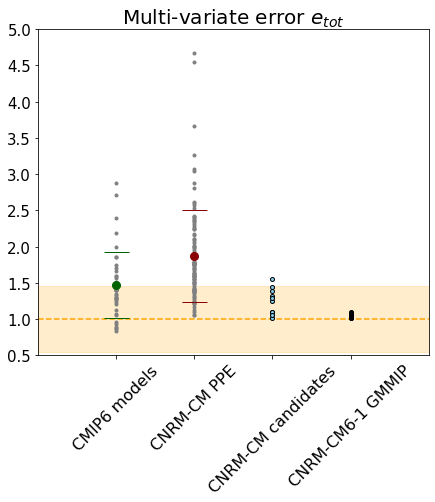

In [72]:
#fig = plt.subplots(figsize=(7,6))
plt.figure(figsize=(7,6))
ax1 = plt.gca()
ax1.set_title('Multi-variate error $e_{tot}$', fontsize=20)
data = {}
data = [e_tot_cmip, e_tot_ppe, e_tot, e_tot_gmmip]
Xlabels = ['CMIP6 models', 'CNRM-CM PPE', 'CNRM-CM candidates', 'CNRM-CM6-1 GMMIP']

ax1.set_xticks([1,1.5,2,2.5])
ax1.set_xticklabels(Xlabels, fontsize=16, rotation=45)
ax1.tick_params(axis='y', which='major', labelsize=15)

ax1.set_xlim(0.5,3.0)
plt.xlim(0.5,3.0)

ax1.axhline(1.0, color='orange', linestyle='--')

for i in e_tot_cmip :
    plt.plot(1, i, marker='.', color='grey')
    
for i in e_tot_ppe :
    plt.plot(1.5, i, marker='.', color='grey')

for i in e_tot :
    plt.plot(2, i, marker='.', color='skyblue', markeredgecolor='black', markersize=8)

for i in e_tot_gmmip :
    ax1.plot(2.5, i, marker='.', color='black', markersize=8)


ax1.axvline(x=1.0, ymin=mean(e_tot_cmip)-std(e_tot_cmip), 
            ymax=mean(e_tot_cmip)+std(e_tot_cmip), 
            color='darkgreen', linestyle='-')

ax1.plot(1, mean(e_tot_cmip)-std(e_tot_cmip), marker='_', color='darkgreen', markersize=25)
ax1.plot(1, mean(e_tot_cmip), marker='o', color='darkgreen', markersize=8)
ax1.plot(1, mean(e_tot_cmip)+std(e_tot_cmip), marker='_', color='darkgreen', markersize=25)

ax1.plot(1.5, mean(e_tot_ppe)-std(e_tot_ppe), marker='_', color='darkred', markersize=25)
ax1.plot(1.5, mean(e_tot_ppe), marker='o', color='darkred', markersize=8)
ax1.plot(1.5, mean(e_tot_ppe)+std(e_tot_ppe), marker='_', color='darkred', markersize=25)

ax1.axhspan((1 - std(e_tot_cmip)),(1+std(e_tot_cmip)), color = 'orange', alpha=0.2)
plt.ylim(0.5,5)

ax1.set_ylabel=('$e_tot$ (no units)')

# Save figure ---------------
name_fig='Fig_candidates_e_tot_rev.png'
plt.savefig("/data/home/globc/peatier/PPE/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
#----------------------------

plt.show()

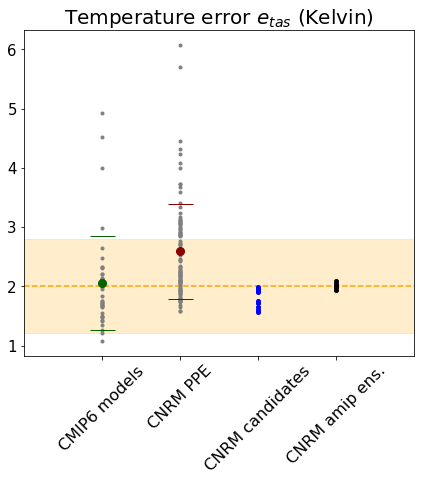

In [113]:
var='tas'

plt.figure(figsize=(7,6))
ax1 = plt.gca()
ax1.set_title('Temperature error $e_{tas}$ (Kelvin)', fontsize=20)
data = {}
data = [e_cmip[var], e_ppe, e_tot, e_tot_gmmip]
Xlabels = ['CMIP6 models', 'CNRM PPE', 'CNRM candidates', 'CNRM amip ens.']

ax1.set_xticks([1,1.5,2,2.5])
ax1.set_xticklabels(Xlabels, fontsize=16, rotation=45)
ax1.tick_params(axis='y', which='major', labelsize=15)

ax1.set_xlim(0.5,3.0)
plt.xlim(0.5,3.0)

ax1.axhline(e_p1[var], color='orange', linestyle='--')

for i in e_cmip[var] :
    ax1.plot(1, i, marker='.', color='grey')
    
for i in e_ppe[var] :
    ax1.plot(1.5, i, marker='.', color='grey')

for i in e_sel[var] :
    ax1.plot(2, i, marker='.', color='blue', markersize=8)

for i in e_gmmip[var] :
    ax1.plot(2.5, i, marker='.', color='black', markersize=8)


ax1.plot(1, mean(e_cmip[var])-std(e_cmip[var]), marker='_', color='darkgreen', markersize=25)
ax1.plot(1, mean(e_cmip[var]), marker='o', color='darkgreen', markersize=8)
ax1.plot(1, mean(e_cmip[var])+std(e_cmip[var]), marker='_', color='darkgreen', markersize=25)

ax1.plot(1.5, mean(e_ppe[var])-std(e_ppe[var]), marker='_', color='darkred', markersize=25)
ax1.plot(1.5, mean(e_ppe[var]), marker='o', color='darkred', markersize=8)
ax1.plot(1.5, mean(e_ppe[var])+std(e_ppe[var]), marker='_', color='darkred', markersize=25)

ax1.axhspan((e_p1[var] - std(e_cmip[var])),(e_p1[var]+std(e_cmip[var])), 
            color = 'orange', alpha=0.2)

# Save figure ---------------
name_fig='Fig_candidates_e_'+var+'_rev.png'
plt.savefig("/data/home/globc/peatier/PPE/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
#----------------------------


plt.show()

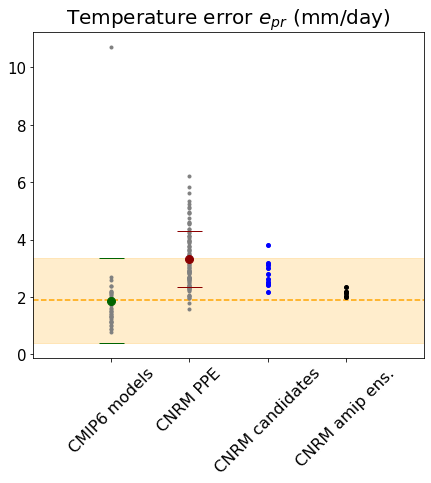

In [114]:
var='pr'
units = 'mm/day'

plt.figure(figsize=(7,6))
ax1 = plt.gca()
ax1.set_title('Temperature error $e_{'+var+'}$ ('+units+')', fontsize=20)
data = {}
data = [e_cmip[var], e_ppe, e_tot, e_tot_gmmip]
Xlabels = ['CMIP6 models', 'CNRM PPE', 'CNRM candidates', 'CNRM amip ens.']

ax1.set_xticks([1,1.5,2,2.5])
ax1.set_xticklabels(Xlabels, fontsize=16, rotation=45)
ax1.tick_params(axis='y', which='major', labelsize=15)

ax1.set_xlim(0.5,3.0)
plt.xlim(0.5,3.0)

ax1.axhline(e_p1[var], color='orange', linestyle='--')

for i in e_cmip[var] :
    ax1.plot(1, i, marker='.', color='grey')
    
for i in e_ppe[var] :
    ax1.plot(1.5, i, marker='.', color='grey')

for i in e_sel[var] :
    ax1.plot(2, i, marker='.', color='blue', markersize=8)

for i in e_gmmip[var] :
    ax1.plot(2.5, i, marker='.', color='black', markersize=8)


ax1.plot(1, mean(e_cmip[var])-std(e_cmip[var]), marker='_', color='darkgreen', markersize=25)
ax1.plot(1, mean(e_cmip[var]), marker='o', color='darkgreen', markersize=8)
ax1.plot(1, mean(e_cmip[var])+std(e_cmip[var]), marker='_', color='darkgreen', markersize=25)

ax1.plot(1.5, mean(e_ppe[var])-std(e_ppe[var]), marker='_', color='darkred', markersize=25)
ax1.plot(1.5, mean(e_ppe[var]), marker='o', color='darkred', markersize=8)
ax1.plot(1.5, mean(e_ppe[var])+std(e_ppe[var]), marker='_', color='darkred', markersize=25)

ax1.axhspan((e_p1[var] - std(e_cmip[var])),(e_p1[var]+std(e_cmip[var])), 
            color = 'orange', alpha=0.2)

# Save figure ---------------
name_fig='Fig_candidates_e_'+var+'_rev.png'
plt.savefig("/data/home/globc/peatier/PPE/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
#----------------------------


plt.show()

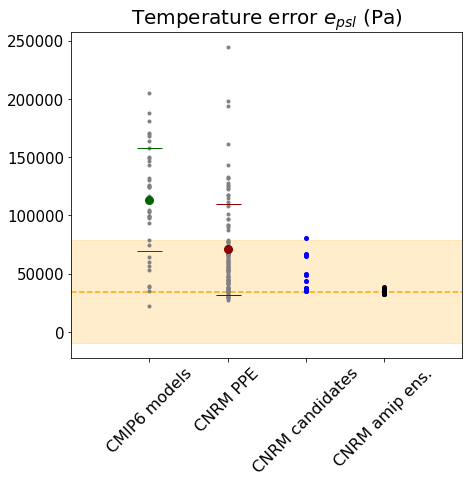

In [115]:
var='psl'
units = 'Pa'

plt.figure(figsize=(7,6))
ax1 = plt.gca()
ax1.set_title('Temperature error $e_{'+var+'}$ ('+units+')', fontsize=20)
data = {}
data = [e_cmip[var], e_ppe, e_tot, e_tot_gmmip]
Xlabels = ['CMIP6 models', 'CNRM PPE', 'CNRM candidates', 'CNRM amip ens.']

ax1.set_xticks([1,1.5,2,2.5])
ax1.set_xticklabels(Xlabels, fontsize=16, rotation=45)
ax1.tick_params(axis='y', which='major', labelsize=15)

ax1.set_xlim(0.5,3.0)
plt.xlim(0.5,3.0)

ax1.axhline(e_p1[var], color='orange', linestyle='--')

for i in e_cmip[var] :
    ax1.plot(1, i, marker='.', color='grey')
    
for i in e_ppe[var] :
    ax1.plot(1.5, i, marker='.', color='grey')

for i in e_sel[var] :
    ax1.plot(2, i, marker='.', color='blue', markersize=8)

for i in e_gmmip[var] :
    ax1.plot(2.5, i, marker='.', color='black', markersize=8)


ax1.plot(1, mean(e_cmip[var])-std(e_cmip[var]), marker='_', color='darkgreen', markersize=25)
ax1.plot(1, mean(e_cmip[var]), marker='o', color='darkgreen', markersize=8)
ax1.plot(1, mean(e_cmip[var])+std(e_cmip[var]), marker='_', color='darkgreen', markersize=25)

ax1.plot(1.5, mean(e_ppe[var])-std(e_ppe[var]), marker='_', color='darkred', markersize=25)
ax1.plot(1.5, mean(e_ppe[var]), marker='o', color='darkred', markersize=8)
ax1.plot(1.5, mean(e_ppe[var])+std(e_ppe[var]), marker='_', color='darkred', markersize=25)

ax1.axhspan((e_p1[var] - std(e_cmip[var])),(e_p1[var]+std(e_cmip[var])), 
            color = 'orange', alpha=0.2)

# Save figure ---------------
name_fig='Fig_candidates_e_'+var+'_rev.png'
plt.savefig("/data/home/globc/peatier/PPE/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
#----------------------------


plt.show()

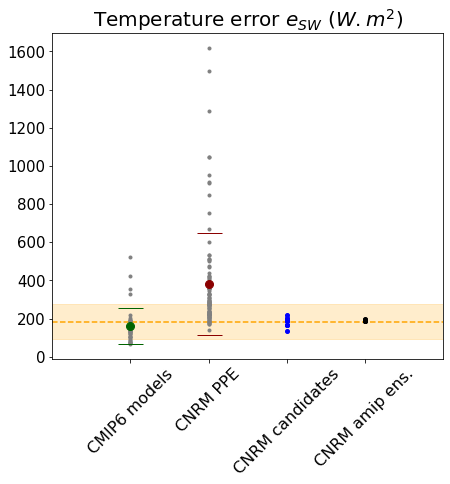

In [116]:
var='SW'
units = '$W.m^{2}$'

plt.figure(figsize=(7,6))
ax1 = plt.gca()
ax1.set_title('Temperature error $e_{'+var+'}$ ('+units+')', fontsize=20)
data = {}
data = [e_cmip[var], e_ppe, e_tot, e_tot_gmmip]
Xlabels = ['CMIP6 models', 'CNRM PPE', 'CNRM candidates', 'CNRM amip ens.']

ax1.set_xticks([1,1.5,2,2.5])
ax1.set_xticklabels(Xlabels, fontsize=16, rotation=45)
ax1.tick_params(axis='y', which='major', labelsize=15)

ax1.set_xlim(0.5,3.0)
plt.xlim(0.5,3.0)

ax1.axhline(e_p1[var], color='orange', linestyle='--')

for i in e_cmip[var] :
    ax1.plot(1, i, marker='.', color='grey')
    
for i in e_ppe[var] :
    ax1.plot(1.5, i, marker='.', color='grey')

for i in e_sel[var] :
    ax1.plot(2, i, marker='.', color='blue', markersize=8)

for i in e_gmmip[var] :
    ax1.plot(2.5, i, marker='.', color='black', markersize=8)


ax1.plot(1, mean(e_cmip[var])-std(e_cmip[var]), marker='_', color='darkgreen', markersize=25)
ax1.plot(1, mean(e_cmip[var]), marker='o', color='darkgreen', markersize=8)
ax1.plot(1, mean(e_cmip[var])+std(e_cmip[var]), marker='_', color='darkgreen', markersize=25)

ax1.plot(1.5, mean(e_ppe[var])-std(e_ppe[var]), marker='_', color='darkred', markersize=25)
ax1.plot(1.5, mean(e_ppe[var]), marker='o', color='darkred', markersize=8)
ax1.plot(1.5, mean(e_ppe[var])+std(e_ppe[var]), marker='_', color='darkred', markersize=25)

ax1.axhspan((e_p1[var] - std(e_cmip[var])),(e_p1[var]+std(e_cmip[var])), 
            color = 'orange', alpha=0.2)

# Save figure ---------------
name_fig='Fig_candidates_e_'+var+'_rev.png'
plt.savefig("/data/home/globc/peatier/PPE/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
#----------------------------


plt.show()